In [1]:
import os

import time

from pathlib import Path

import pandas as pd

import skimage
from skimage import io
import skimage.exposure as skie

import napari
from napari.utils import nbscreenshot

import numpy as np
from matplotlib import pyplot as plt

import bigfish
import bigfish.stack as stack
import bigfish.multistack as multistack
import bigfish.plot as fishplt
import bigfish.segmentation as segment
import bigfish.detection as detection

import cellpose
from cellpose import models, plot, utils
from cellpose import io as cpio

/Users/alexandergillis/opt/anaconda3/envs/PyImg37/lib/python3.7/site-packages/bigfish/segmentation/nuc_segmentation.py:16: FutureWarning: The `skimage.morphology.selem` module is deprecated and will be removed in scikit-image 1.0 (`skimage.morphology.selem` has been moved to `skimage.morphology.footprints`).
  from skimage.morphology.selem import disk
/Users/alexandergillis/opt/anaconda3/envs/PyImg37/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(os.getcwd())

/Users/alexandergillis/Desktop/FISH images temp storage/220516/TIF


In [3]:
in_path = "/Users/alexandergillis/Desktop/FISH images temp storage/tetraspeck/"

input_list = []
for file in os.listdir(in_path):
    if file.endswith(".tif"):
        input_list.append(file)
        
input_list.sort()
print(input_list)

['220509_TetraSpecks_488_642excite_LP560_zstack.tif']


In [4]:
img = io.imread(os.path.join(in_path, input_list[0]))

In [5]:
print(img.shape)
img_C1 = img[:,0,:,:]
img_C2 = img[:,1,:,:]

img_C1_max = np.max(img_C1,axis = 0)
img_C2_max = np.max(img_C2,axis = 0)

(70, 2, 1280, 1280)


In [7]:
imgs = [img_C1_max, img_C2_max]
imgs_flt = []
for i in imgs:
    img_st = stack.rescale(i, channel_to_stretch = None)
    img_flt = stack.log_filter(img_st,sigma = 3)
    imgs_flt.append(img_flt)

In [8]:
imgs_Z = [img_C1, img_C2]
imgs_flt_Z = []
for i in imgs_Z:
    img_st = stack.rescale(i, channel_to_stretch = None)
    img_flt = stack.log_filter(img_st,sigma = 3)
    imgs_flt_Z.append(img_flt)

In [9]:
spots, threshold = detection.detect_spots(
    images=imgs_flt, 
    return_threshold=True, 
    voxel_size=(97, 97),  # in nanometer (one value per dimension zyx)
    spot_radius=(150, 150))  # in nanometer (one value per dimension zyx)

In [62]:
spots_Z, threshold = detection.detect_spots(
    images=imgs_flt_Z, 
    return_threshold=True, 
    voxel_size=(150, 97, 97),  # in nanometer (one value per dimension zyx)
    spot_radius=(300, 150, 150))  # in nanometer (one value per dimension zyx)

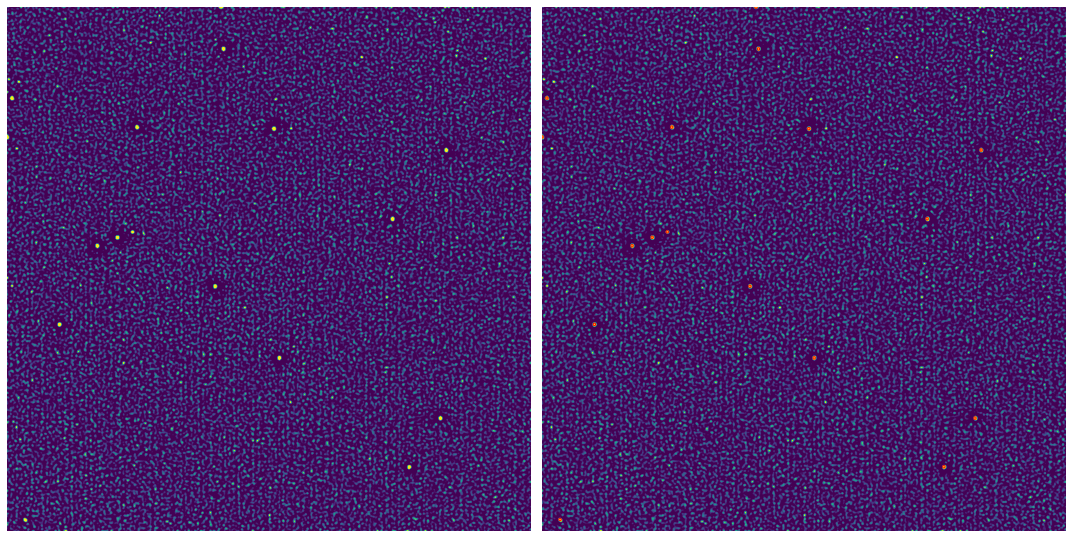

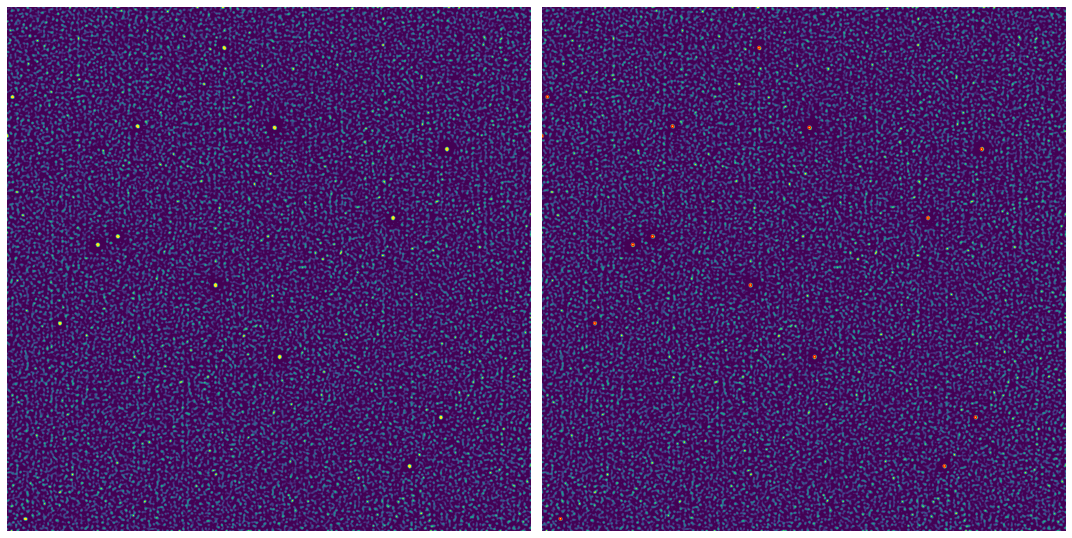

In [10]:
fishplt.plot_detection(imgs_flt[0],spots[0],contrast=True)
fishplt.plot_detection(imgs_flt[1],spots[1],contrast=True)

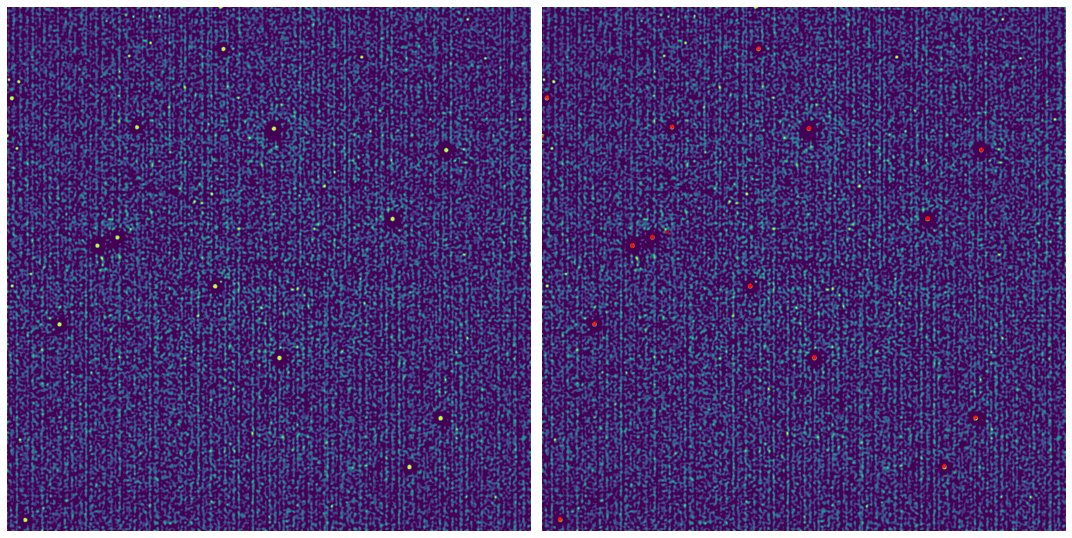

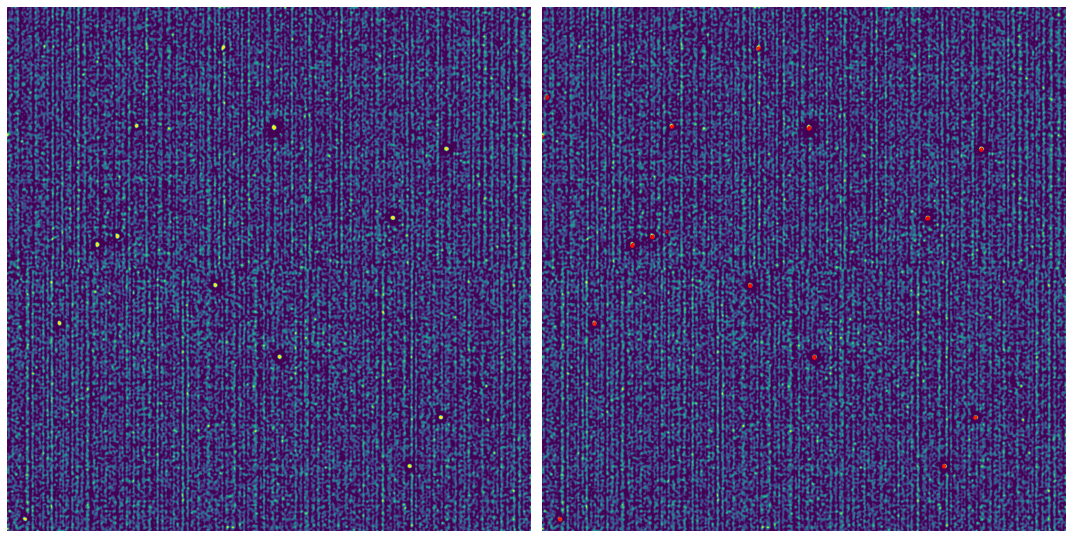

In [66]:
fishplt.plot_detection(imgs_flt_Z[0][35],spots_Z,contrast=True)
fishplt.plot_detection(imgs_flt_Z[1][35],spots_Z,contrast=True)

In [11]:
c1_xvals = []
c1_yvals = []

for row in spots[0]:
    xval = row[0]
    c1_xvals.append(xval)
    yval = row[1]
    c1_yvals.append(yval)
    
c2_xvals = []
c2_yvals = []

for row in spots[1]:
    xval = row[0]
    c2_xvals.append(xval)
    yval = row[1]
    c2_yvals.append(yval)

In [14]:
print(c1_xvals)
print(c2_xvals)

[0, 102, 222, 293, 297, 317, 349, 517, 549, 562, 583, 682, 775, 857, 1004, 1123, 1252]
[99, 219, 291, 294, 315, 347, 515, 560, 580, 679, 772, 854, 1002, 1121, 1250]


In [16]:
max_match_C1 = []
max_match_C2 = []

for indx,x in enumerate(c1_xvals):
    if x-2 in c2_xvals:
        max_match_C1.append(indx)
        max_match_C2.append(c2_xvals.index(x-2))
    elif x-3 in c2_xvals:
        max_match_C1.append(indx)
        max_match_C2.append(c2_xvals.index(x-3))

In [20]:
x1 = []
y1 = []
x2 = []
y2 = []

for indx, i in enumerate(max_match_C1):
    x1.append(c1_xvals[i])
    y1.append(c1_yvals[i])    
    x2.append(c2_xvals[max_match_C2[indx]])
    y2.append(c2_yvals[max_match_C2[indx]])

In [23]:
Bead_XY = pd.DataFrame({
    "Channel1_X" : x1,
    "Channel1_Y" : y1,
    "Channel2_X" : x2,
    "Channel2_Y" : y2    
})

Bead_XY["Xdiff"] = Bead_XY["Channel1_X"] - Bead_XY["Channel2_X"]
Bead_XY["Ydiff"] = Bead_XY["Channel1_Y"] - Bead_XY["Channel2_Y"]

In [24]:
Bead_XY

,Channel1_X,Channel1_Y,Channel2_X,Channel2_Y,Xdiff,Ydiff
0,102,529,99,530,3,-1
1,222,12,219,13,3,-1
2,293,317,291,319,2,-2
3,297,652,294,653,3,-1
4,317,0,315,0,2,0
5,349,1073,347,1074,2,-1
6,517,941,515,943,2,-2
7,562,269,560,270,2,-1
8,583,220,580,222,3,-2
9,682,508,679,509,3,-1


In [30]:
print(Bead_XY["Xdiff"].mean() , Bead_XY["Ydiff"].mean())

2.466666666666667 -1.1333333333333333


In [49]:
print(x1)
print(y1)

xy1 = []
xy2 = []

for indx, i in enumerate(x1):
    xy1.append([i,y1[indx]])
    
for indx, i in enumerate(x2):
    xy2.append([i,y2[indx]])

[102, 222, 293, 297, 317, 349, 517, 562, 583, 682, 775, 857, 1004, 1123, 1252]
[529, 12, 317, 652, 0, 1073, 941, 269, 220, 508, 128, 665, 1058, 982, 44]


In [57]:
print(xy1)
print(xy2)

channel1 = np.array(xy1)
channel2 = np.array(xy2)

[[102, 529], [222, 12], [293, 317], [297, 652], [317, 0], [349, 1073], [517, 941], [562, 269], [583, 220], [682, 508], [775, 128], [857, 665], [1004, 1058], [1123, 982], [1252, 44]]
[[99, 530], [219, 13], [291, 319], [294, 653], [315, 0], [347, 1074], [515, 943], [560, 270], [580, 222], [679, 509], [772, 129], [854, 666], [1002, 1059], [1121, 983], [1250, 45]]


In [64]:
from skimage import transform

trns = transform.EuclideanTransform()

In [65]:
trns.estimate(src = channel1, dst = channel2)

True

In [87]:
move = transform.warp(img_C1_max,trns)
move = skie.rescale_intensity(move,in_range = (move.min(),move.max()), out_range = (0,1))
img_C1_max = skie.rescale_intensity(img_C1_max,in_range = (img_C1_max.min(),img_C1_max.max()), out_range = (0,1))
img_C2_max = skie.rescale_intensity(img_C2_max,in_range = (img_C2_max.min(),img_C2_max.max()), out_range = (0,1))

In [88]:
comp = np.stack([img_C2_max,img_C1_max,move])
print(comp.shape)

(3, 1280, 1280)


In [89]:
look = napari.view_image(comp)

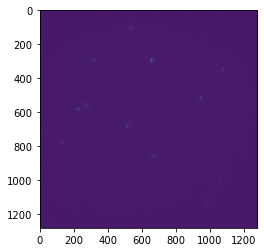

In [71]:
plt.imshow(move)

In [36]:
pth = os.getcwd()
print(pth)

/Users/alexandergillis/Desktop/FISH images temp storage/220516/TIF


In [42]:
real_img = io.imread(str(os.path.join(pth, "220516_chamberslide_Well8_FISH647_DDXRFP_488NHS_DAPI_zstack_001.tif")))

(50, 1280, 1280, 4)
(1280, 1280, 4)


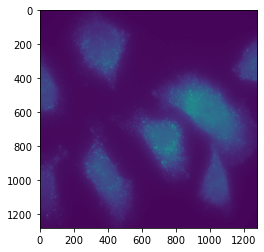

In [45]:
print(real_img.shape)
real_img_max = np.max(real_img,axis = 0)
print(real_img_max.shape)
plt.imshow(real_img_max[:,:,0])

In [73]:
c1_z_xvals = []
c1_z_yvals = []
c1_z_zvals = []

for row in spots_Z[0]:
    zval = row[0]
    c1_z_zvals.append(zval)
    xval = row[1]
    c1_z_xvals.append(xval)
    yval = row[2]
    c1_z_yvals.append(yval)
    
c2_z_xvals = []
c2_z_yvals = []
c2_z_zvals = []

for row in spots_Z[1]:
    zval = row[0]
    c2_z_zvals.append(zval)
    xval = row[1]
    c2_z_xvals.append(xval)
    yval = row[2]
    c2_z_yvals.append(yval)

In [98]:
print(c1_z_xvals)
print(c2_z_xvals)

match_C1 = []
match_C2 = []

for indx,x in enumerate(c1_z_xvals):
    if x-2 in c2_z_xvals:
        match_C1.append(indx)
        match_C2.append(c2_z_xvals.index(x-2))
    elif x-3 in c2_z_xvals:
        match_C1.append(indx)
        match_C2.append(c2_z_xvals.index(x-3))

[549, 1004, 1123, 517, 682, 857, 1253, 349, 775, 297, 562, 583, 102, 293, 222, 317, 857, 682, 349, 517, 563, 297, 584]
[1002, 1121, 854, 515, 679, 1250, 772, 295, 347, 560, 580, 291, 100, 219, 516, 295]


In [117]:
print(match_C1)
print(match_C2)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21]
[0, 1, 3, 4, 2, 5, 8, 6, 7, 9, 10, 12, 11, 13, 2, 4, 8, 3, 9, 7]


In [107]:
print(len(match_C1))
print(len(match_C2))

x1 = []
y1 = []
z1 = []
x2 = []
y2 = []
z2 = []

for indx, i in enumerate(match_C1):
    x1.append(c1_z_xvals[i])
    y1.append(c1_z_yvals[i])    
    z1.append(c1_z_zvals[i])
    x2.append(c2_z_xvals[match_C2[indx]])
    y2.append(c2_z_yvals[match_C2[indx]])
    z2.append(c2_z_zvals[match_C2[indx]])

20
20


In [108]:
print(x1)
print(x2)
print(y1)
print(y2)

[1004, 1123, 517, 682, 857, 1253, 349, 775, 297, 562, 583, 102, 293, 222, 857, 682, 349, 517, 563, 297]
[1002, 1121, 515, 679, 854, 1250, 347, 772, 295, 560, 580, 100, 291, 219, 854, 679, 347, 515, 560, 295]
[1058, 982, 941, 508, 665, 44, 1073, 128, 652, 269, 220, 528, 317, 12, 666, 509, 1074, 943, 270, 653]
[1060, 983, 943, 509, 666, 44, 1074, 129, 653, 270, 222, 530, 319, 13, 666, 509, 1074, 943, 270, 653]


In [109]:
Bead_XYZ = pd.DataFrame({
    "Channel1_Z" : z1,
    "Channel1_X" : x1,
    "Channel1_Y" : y1,
    "Channel2_Z" : z2,
    "Channel2_X" : x2,
    "Channel2_Y" : y2    
})

In [114]:
Bead_XYZ["Zdiff"] = Bead_XYZ["Channel1_Z"] - Bead_XYZ["Channel2_Z"]
Bead_XYZ["Xdiff"] = Bead_XYZ["Channel1_X"] - Bead_XYZ["Channel2_X"]
Bead_XYZ["Ydiff"] = Bead_XYZ["Channel1_Y"] - Bead_XYZ["Channel2_Y"]

In [115]:
Bead_XYZ

,Channel1_Z,Channel1_X,Channel1_Y,Channel2_Z,Channel2_X,Channel2_Y,Xdiff,Zdiff,Ydiff
0,33,1004,1058,37,1002,1060,2,-4,-2
1,34,1123,982,37,1121,983,2,-3,-1
2,35,517,941,39,515,943,2,-4,-2
3,35,682,508,39,679,509,3,-4,-1
4,35,857,665,38,854,666,3,-3,-1
5,35,1253,44,39,1250,44,3,-4,0
6,36,349,1073,41,347,1074,2,-5,-1
7,36,775,128,40,772,129,3,-4,-1
8,37,297,652,41,295,653,2,-4,-1
9,37,562,269,41,560,270,2,-4,-1
